# Comparing the Demographics between Charter and Public Schools in Massachusetts

## The Question

In this notebook, we will examine whether or not charter schools in Massachusetts have significantly different racial demographics than their neighboring public schools. My hypothesis is that charter schools will differ the most in more populated and diverse parts of Massachusetts. In particular, we want to see if charter schools are contributing to segregation of students.

In [48]:
# import packages
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np

# set jupyter netbook options
pd.set_option('max_columns',0)
%matplotlib inline

In [49]:
# read data from Mass DOE
schools = pd.read_csv('MA_Public_Schools_2017.csv')

# select columns relevant to racial demographics
school_demographics = schools[['School Code','School Name','School Type','District Name',
                               'District Code','Zip', 'TOTAL_Enrollment', '% African American',
                               '% Asian','% Hispanic','% White','% Native American',
                               '% Native Hawaiian, Pacific Islander','% Multi-Race, Non-Hispanic']].copy()

# grouping data by zip code and aggregating by taking the mean of the percentages for each demographic
school_demographics_by_zip = school_demographics[['School Type','Zip','TOTAL_Enrollment',
                                                  '% African American','% Asian','% Hispanic','% White',
                                                  '% Native American','% Native Hawaiian, Pacific Islander',
                                                  '% Multi-Race, Non-Hispanic']].groupby(['Zip','School Type']).mean().copy()

## Initial Observation

By pivoting on the type of school and taking the average percentage for each demographic, we see that there is a significant difference between charter and public schools. In particular, charter schools appear to be more segregated towards African American and Hispanic students, while public schools seem to be more segregated towards white students.

In [61]:
demographics = ['% African American','% Asian','% Hispanic','% White',
                '% Native American','% Native Hawaiian, Pacific Islander','% Multi-Race, Non-Hispanic']

school_demographics.pivot_table(index = 'School Type', values=demographics)

,% African American,% Asian,% Hispanic,"% Multi-Race, Non-Hispanic",% Native American,"% Native Hawaiian, Pacific Islander",% White
School Type,,,,,,,
Charter School,28.041026,3.900000,32.642308,3.242308,0.297436,0.094872,31.782051
Public School,7.848081,6.145598,18.395993,3.612190,0.230643,0.098138,63.670993


## Diving deeper by zip code

However, this doesn't capture the whole story as Massachusetts is fairly diverse in terms of its racial and cultural make-up. For instance, if a part of Massachusetts is particularly skewed towards one demographic, then a charter school also being skewed towards the same demographic wouldn't represent segregation. To get a better sense of whether or not charter schools are similar in their demographics to public schools, we need to compare schools within the same geographic region.

To address this issue, we group our demographics data by zip code and school type.

In [51]:
# group demographic data by zip code and school type
f = {'TOTAL_Enrollment':'sum', '% African American':'mean','% Asian':'mean','% Hispanic':'mean','% White':'mean',
     '% Native American':'mean','% Native Hawaiian, Pacific Islander':'mean','% Multi-Race, Non-Hispanic':'mean'}

school_demographics_by_zip = school_demographics[['School Type','Zip','TOTAL_Enrollment', '% African American',
    '% Asian','% Hispanic','% White','% Native American','% Native Hawaiian, Pacific Islander',
    '% Multi-Race, Non-Hispanic']].groupby(['Zip','School Type']).agg(f).copy()

Because we want to compare charter schools to public schools that are nearby each other, we need to isolate zip codes with both public and charter schools.

In [52]:
idx = pd.IndexSlice

# slice demographic data by zip codes with public and charter schools
public_and_charter = [i for i in school_demographics['Zip'] if len(school_demographics_by_zip.loc[idx[i]]) == 2]
school_demographics_compare = school_demographics_by_zip.loc[idx[public_and_charter]].copy()

Now that we have separated the data into charter and public schools by zip codes and isolated those zip codes with both types of schools, we want to compare the demographics for each pair of charter and public schools. Since the demographics for each type of schools form a continuous distribution, we use a two-sample goodness of fit test to find the probability of them coming from the same distribution. We can achieve this by using the chi2_contingency function from the scipy.stats package.

In [ ]:
def compare_dist(i):        
    '''Return the p-value of a two-sample chi-squared test for goodness of fit between two distributions.'''
    dist1 = school_demographics_by_zip.loc[idx[i[0]]].iloc[0][1:]
    dist2 = school_demographics_by_zip.loc[idx[i[0]]].iloc[1][1:]
    
    # to avoid 0 values in the distributions, we adjust by 0.1%
    stack = np.vstack((dist1.values, dist2.values))
    chi2, p, dof, expected = chi2_contingency(stack + 0.1)
    
    return p

def total_students(i):
    '''Return the number of students from both charter and public schools for each zip code.'''
    total1 = school_demographics_by_zip.loc[idx[i[0]]].iloc[0][0]
    total2 = school_demographics_by_zip.loc[idx[i[0]]].iloc[1][0]
    
    return int(total1 + total2)

school_demographics_compare['p_value'] = school_demographics_compare.index.map(compare_dist)
school_demographics_compare['num_students'] = school_demographics_compare.index.map(total_students)

By looking at the first 3 zip codes in our data, we can already see that some zip codes have significantly different demographics in their schools and some don't.

In [54]:
school_demographics_compare.head(6)

TOTAL_Enrollment  % African American      ...        p_value  num_students
Zip  School Type                                               ...                             
1022 Charter School               478               24.90      ...       0.000042           844
     Public School                366                4.10      ...       0.000042           844
1027 Charter School               218                0.50      ...       0.550548          2651
     Public School               2433                1.20      ...       0.550548          2651
1035 Charter School               471                4.70      ...       0.000235          1033
     Public School                562                2.95      ...       0.000235          1033

[6 rows x 10 columns]

We can now plot a cumulative distribution function for the calculated p-values above to see exactly how many schools are significantly different from their neighboring public schools.

Text(0.5,1,'CDF for p values from two-sample goodness of fit tests')

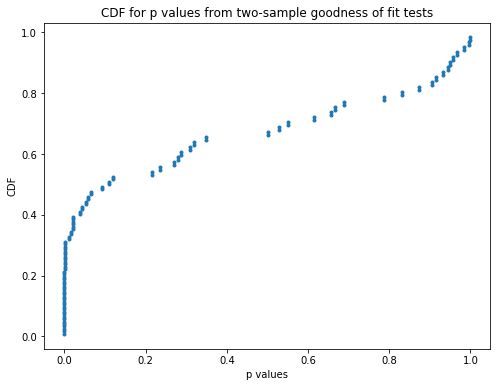

In [55]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    
    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

p_value, cdf = ecdf(school_demographics_compare['p_value'])

plt.figure(figsize=(8,6))
plt.plot(p_value, cdf, marker='.', linestyle='none')
plt.xlabel('p values')
plt.ylabel('CDF')
plt.title('CDF for p values from two-sample goodness of fit tests')

We can see in the above plot that a large proportion of zip codes with both charter and public schools have significantly different demographics in their schools. In particular, we can calculate the exact proportion of zip codes with differing school demographics using a 0.05 level of significance. From our test, this yields 42 % of zip codes.

In [56]:
school_demographics_compare[school_demographics_compare['p_value'] < 0.05]

TOTAL_Enrollment  % African American      ...            p_value  num_students
Zip  School Type                                               ...                                 
1022 Charter School               478           24.900000      ...       4.212260e-05           844
     Public School                366            4.100000      ...       4.212260e-05           844
1035 Charter School               471            4.700000      ...       2.351013e-04          1033
     Public School                562            2.950000      ...       2.351013e-04          1033
1108 Charter School               366           41.800000      ...       6.787733e-04          3251
     Public School               2885           18.337500      ...       6.787733e-04          3251
1129 Charter School              1576           29.800000      ...       1.687322e-02          2163
     Public School                587           15.400000      ...       1.687322e-02          2163
1420 Charter School               370            4.300000      ...       1.798088e-04          7071
     Public School               6701            5.300000      ...       1.798088e-04          7071
1605 Charter School               667           47.100000      ...       1.380159e-08          5390
     Public School               4723           13.711111      ...       1.380159e-08          5390
1606 Charter School              1425           48.500000      ...       9.478425e-04          4820
     Public School               3395           17.200000      ...       9.478425e-04          4820
1752 Charter School               952            2.400000      ...       8.127869e-06          6580
     Public School               5628            3.528571      ...       8.127869e-06          6580
1832 Charter School               567            2.800000      ...       3.811127e-02          4306
     Public School               3739            4.320000      ...       3.811127e-02          4306
1851 Charter School               646           19.800000      ...       4.234322e-02          3272
     Public School               2626            6.800000      ...       4.234322e-02          3272
1906 Charter School               322           35.100000      ...       3.690080e-08          2815
     Public School               2493            4.033333      ...       3.690080e-08          2815
2035 Charter School              1261           36.600000      ...       6.980334e-08          3862
     Public School               2601            4.020000      ...       6.980334e-08          3862
2038 Charter School               447            1.600000      ...       2.143854e-02          6882
     Public School               6435            1.500000      ...       2.143854e-02          6882
2061 Charter School               758           25.100000      ...       1.679729e-05          2950
     Public School               2192            0.450000      ...       1.679729e-05          2950
2115 Charter School               359           44.600000      ...       2.688591e-20          2762
     Public School               2403            8.000000      ...       2.688591e-20          2762
2120 Charter School              1306           56.400000      ...       2.224876e-02          4409
     Public School               3103           34.425000      ...       2.224876e-02          4409
2122 Charter School               674           65.350000      ...       6.214770e-04          3151
     Public School               2477           38.640000      ...       6.214770e-04          3151
2125 Charter School               680           27.500000      ...       5.100404e-08          2800
     Public School               2120           40.742857      ...       5.100404e-08          2800
2127 Charter School               472           46.800000      ...       1.208056e-02          2571
     Public School               2099           34.360000      ...       1.208056e-02          2571
2131 Charter School  

In [57]:
sum(school_demographics_compare['p_value'] < 0.05)/len(school_demographics_compare['p_value'])

0.42622950819672129

To get a better since of why these schools might be significantly different, we slice our data down to just those zip codes where the charter schools are significantly different from their corresponding public schools. Moreover, we can plot these zip codes on a map of Massachusetts to see if there might be factors related to their geographic location.

In [58]:
sig_diff_school_demographics_compare = school_demographics_compare['p_value'] < 0.05

In [59]:
# save zip codes from our list of significantly different zip codes to plot in Tableau
zips = pd.DataFrame(sig_diff_school_demographics_compare.index.get_level_values(level='Zip').values)
zips.drop_duplicates(inplace=True)
zips.to_csv('zips.csv')

To see whether or not there's a geographic influence on the difference between charter and public schools, I imported the zip codes from above into Tableau and overlayed them on a map of Massachusetts. Then, I used Tableau to shade zip codes according to their populations in 2017. 

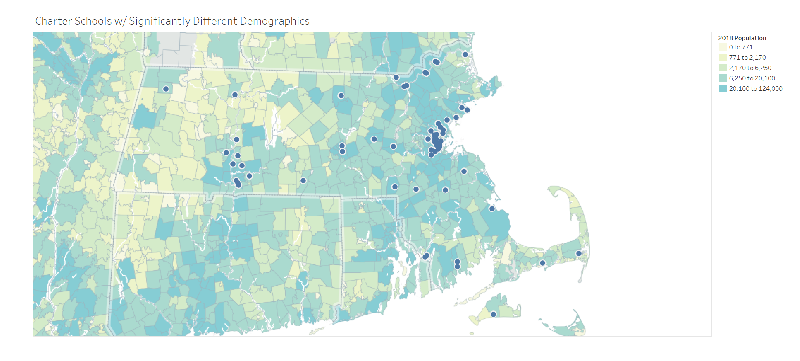

In [60]:
# read and plot our image created by Tableau
zip_plot = mpimg.imread('Charter v Public Demo Zips.png')
plt.figure(figsize=(15,6))
plt.axis('off')
plt.imshow(zip_plot)

Examining the above map, there seems to be a correlation between having significantly different school demographics and population as well as being in more urban parts of Massachusetts.

## Conclusions

1. A siginificant percentage of zip codes with both charter and public schools have differing racial demographics between these types of schools.

2. These zip codes tend to be more populated and urban.

3. In some zip codes, there is moderate (at least 50%) to significant (at least 80%) segregation towards a specific minority.